In [20]:
!pip install git+https://github.com/ses0137/gym-bandits.git
!pip install -U ipywidgets notebook

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/ses0137/gym-bandits.git to /tmp/pip-req-build-0l3hxwmh
  Running command git clone -q https://github.com/ses0137/gym-bandits.git /tmp/pip-req-build-0l3hxwmh
  Resolved https://github.com/ses0137/gym-bandits.git to commit c28d7e73e74daba62d1f348af822981269bfbd22
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 14.3 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 13.1 MB 31.7 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 23.4 MB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 24.5 MB/s eta 0:00:01
     |████████████████████████████████| 383 kB 29.2 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 69.6 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 8.3 MB/s 

     |████████████████████████████████| 88 kB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 360 kB 36.2 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 33.8 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 32.9 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 44.2 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 43.7 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 35.3 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 51.2 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 48.4 MB/s eta 0:00:01


  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.17.3
    Uninstalling jsonschema-4.17.3:
      Successfully uninstalled jsonschema-4.17.3
  Attempting uninstall: send2trash
    Found existing installation: Send2Trash 1.8.0
    Uninstalling Send2Trash-1.8.0:
      Successfully uninstalled Send2Trash-1.8.0
  Attempting uninstall: requests
    Found existing installation: requests 2.28.2
    Uninstalling requests-2.28.2:
      Successfully uninstalled requests-2.28.2
  Attempting uninstall: jupyterlab-server
    Found existing installation: jupyterlab-server 1.2.0
    Uninstalling jupyterlab-server-1.2.0:
      Successfully uninstalled jupyterlab-server-1.2.0
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 2.3.2
    Uninstalling jupyterlab-2.3.2:
      Successfully uninstalled jupyterlab-2.3.2
  Attempting uninstall: notebook
    Found existing installation: notebook 6.4.10
    Uninstalling notebook-6.4.10:
      Successfully

In [34]:
import ipywidgets as widgets
from IPython.display import display

progress = widgets.IntProgress(value=30, min=0, max=100)
display(progress)


IntProgress(value=30)

In [3]:
# Bandits

In [4]:
import warnings ; warnings.filterwarnings('ignore')

import gymnasium as gym
import gym_bandits
import numpy as np
from scipy.special import softmax as softmax_fn
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle

import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [41]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

# Baseline strategies

In [42]:
def pure_exploitation(env, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int64)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int64)
    name = 'Pure exploitation'

    # 한 번 초기화
    _ = env.reset()

    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name,
                  leave=False):
        action = np.argmax(Q)
        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

        # bandit: 매 스텝마다 done -> 다시 reset
        _ = env.reset()

    return name, returns, Qe, actions

In [50]:
def pure_exploration(env, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int64)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int64)
    name = 'Pure exploration'

    _ = env.reset()

    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name,
                  leave=False):
        action = np.random.randint(len(Q))
        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

        _ = env.reset()

    return name, returns, Qe, actions

# Simple strategies

In [51]:
def epsilon_greedy(env, epsilon=0.01, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int64)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int64)
    name = f'Epsilon-Greedy {epsilon}'

    _ = env.reset()

    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name,
                  leave=False):
        if np.random.uniform() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

        _ = env.reset()

    return name, returns, Qe, actions

In [52]:
def lin_dec_epsilon_greedy(env,
                           init_epsilon=1.0,
                           min_epsilon=0.01,
                           decay_ratio=0.05,
                           n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int64)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int64)
    name = f'Lin Epsilon-Greedy {init_epsilon}, {min_epsilon}, {decay_ratio}'

    _ = env.reset()

    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name,
                  leave=False):
        decay_episodes = n_episodes * decay_ratio
        epsilon = 1 - e / decay_episodes
        epsilon *= init_epsilon - min_epsilon
        epsilon += min_epsilon
        epsilon = np.clip(epsilon, min_epsilon, init_epsilon)

        if np.random.uniform() > epsilon:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

        _ = env.reset()

    return name, returns, Qe, actions

In [53]:
def exp_dec_epsilon_greedy(env,
                           init_epsilon=1.0,
                           min_epsilon=0.01,
                           decay_ratio=0.1,
                           n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int64)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int64)

    decay_episodes = int(n_episodes * decay_ratio)
    rem_episodes = n_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0, decay_episodes)
    epsilons *= init_epsilon - min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_episodes), 'edge')

    name = f'Exp Epsilon-Greedy {init_epsilon}, {min_epsilon}, {decay_ratio}'
    _ = env.reset()

    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name,
                  leave=False):
        if np.random.uniform() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))

        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

        _ = env.reset()

    return name, returns, Qe, actions

In [54]:
def optimistic_initialization(env,
                              optimistic_estimate=1.0,
                              initial_count=100,
                              n_episodes=1000):
    Q = np.full((env.action_space.n), optimistic_estimate, dtype=np.float64)
    N = np.full((env.action_space.n), initial_count, dtype=np.int64)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int64)
    name = f'Optimistic {optimistic_estimate}, {initial_count}'

    _ = env.reset()

    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name,
                  leave=False):
        action = np.argmax(Q)

        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

        _ = env.reset()

    return name, returns, Qe, actions

# Two-Armed Bandit environments

In [55]:
b2_Vs = []
for seed in SEEDS:
    env_name = 'BanditTwoArmedUniform-v0'
    env = gym.make(env_name, seed=seed).unwrapped
    # bandit의 분포 확인
    p_dist = env.p_dist
    r_dist = env.r_dist
    b2_Q = np.array(p_dist * r_dist)
    print('Two-Armed Bandit environment with seed', seed)
    print('Probability of reward:', p_dist)
    print('Reward:', r_dist)
    print('Q(.):', b2_Q)
    b2_Vs.append(np.max(b2_Q))
    print('V*:', b2_Vs[-1])
    print()

print('Mean V* across all seeds:', np.mean(b2_Vs))

Two-Armed Bandit environment with seed 12
Probability of reward: [0.25082446 0.94675294]
Reward: [1 1]
Q(.): [0.25082446 0.94675294]
V*: 0.9467529428594246

Two-Armed Bandit environment with seed 34
Probability of reward: [0.00402824 0.87217691]
Reward: [1 1]
Q(.): [0.00402824 0.87217691]
V*: 0.8721769142705423

Two-Armed Bandit environment with seed 56
Probability of reward: [0.72612605 0.01690281]
Reward: [1 1]
Q(.): [0.72612605 0.01690281]
V*: 0.72612604996354

Two-Armed Bandit environment with seed 78
Probability of reward: [0.41886309 0.9151353 ]
Reward: [1 1]
Q(.): [0.41886309 0.9151353 ]
V*: 0.9151353037895024

Two-Armed Bandit environment with seed 90
Probability of reward: [0.37233278 0.68189711]
Reward: [1 1]
Q(.): [0.37233278 0.68189711]
V*: 0.6818971075342127

Mean V* across all seeds: 0.8284176636834444


# Running simple strategies on Two-Armed Bandit environments

In [56]:
def b2_run_simple_strategies_experiment(env_name='BanditTwoArmedUniform-v0'):
    results = {}
    experiments = [
        # baseline strategies
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),

        # epsilon greedy
        lambda env: epsilon_greedy(env, epsilon=0.07),
        lambda env: epsilon_greedy(env, epsilon=0.1),

        # epsilon greedy linearly decaying
        lambda env: lin_dec_epsilon_greedy(env,
                                           init_epsilon=1.0,
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: lin_dec_epsilon_greedy(env,
                                           init_epsilon=0.3,
                                           min_epsilon=0.001,
                                           decay_ratio=0.1),

        # epsilon greedy exponentially decaying
        lambda env: exp_dec_epsilon_greedy(env,
                                           init_epsilon=1.0,
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: exp_dec_epsilon_greedy(env,
                                           init_epsilon=0.3,
                                           min_epsilon=0.0,
                                           decay_ratio=0.3),

        # optimistic
        lambda env: optimistic_initialization(env,
                                              optimistic_estimate=1.0,
                                              initial_count=10),
        lambda env: optimistic_initialization(env,
                                              optimistic_estimate=1.0,
                                              initial_count=50),
    ]
    for env_seed in tqdm(SEEDS, desc='All experiments'):
        # 여기서 bandit 환경 생성
        env = gym.make(env_name, seed=env_seed)
        _ = env.reset()
        true_Q = np.array(env.unwrapped.p_dist * env.unwrapped.r_dist)
        opt_V = np.max(true_Q)

        for seed_ in tqdm(SEEDS, desc='All environments', leave=False):
            # 매 실험마다 시드를 고정
            env.reset(seed=seed_)
            np.random.seed(seed_)
            random.seed(seed_)

            for experiment in tqdm(experiments,
                                   desc=f'Experiments with seed {seed_}',
                                   leave=False):
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)

                if name not in results:
                    results[name] = {}
                if 'Re' not in results[name]:
                    results[name]['Re'] = []
                if 'Qe' not in results[name]:
                    results[name]['Qe'] = []
                if 'Ae' not in results[name]:
                    results[name]['Ae'] = []
                if 'cum_regret' not in results[name]:
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name]:
                    results[name]['episode_mean_rew'] = []

                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results


b2_results_s = b2_run_simple_strategies_experiment()


All experiments:   0%|          | 0/5 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

# Plotting results of simple strategies on Two-Armed Bandit environments

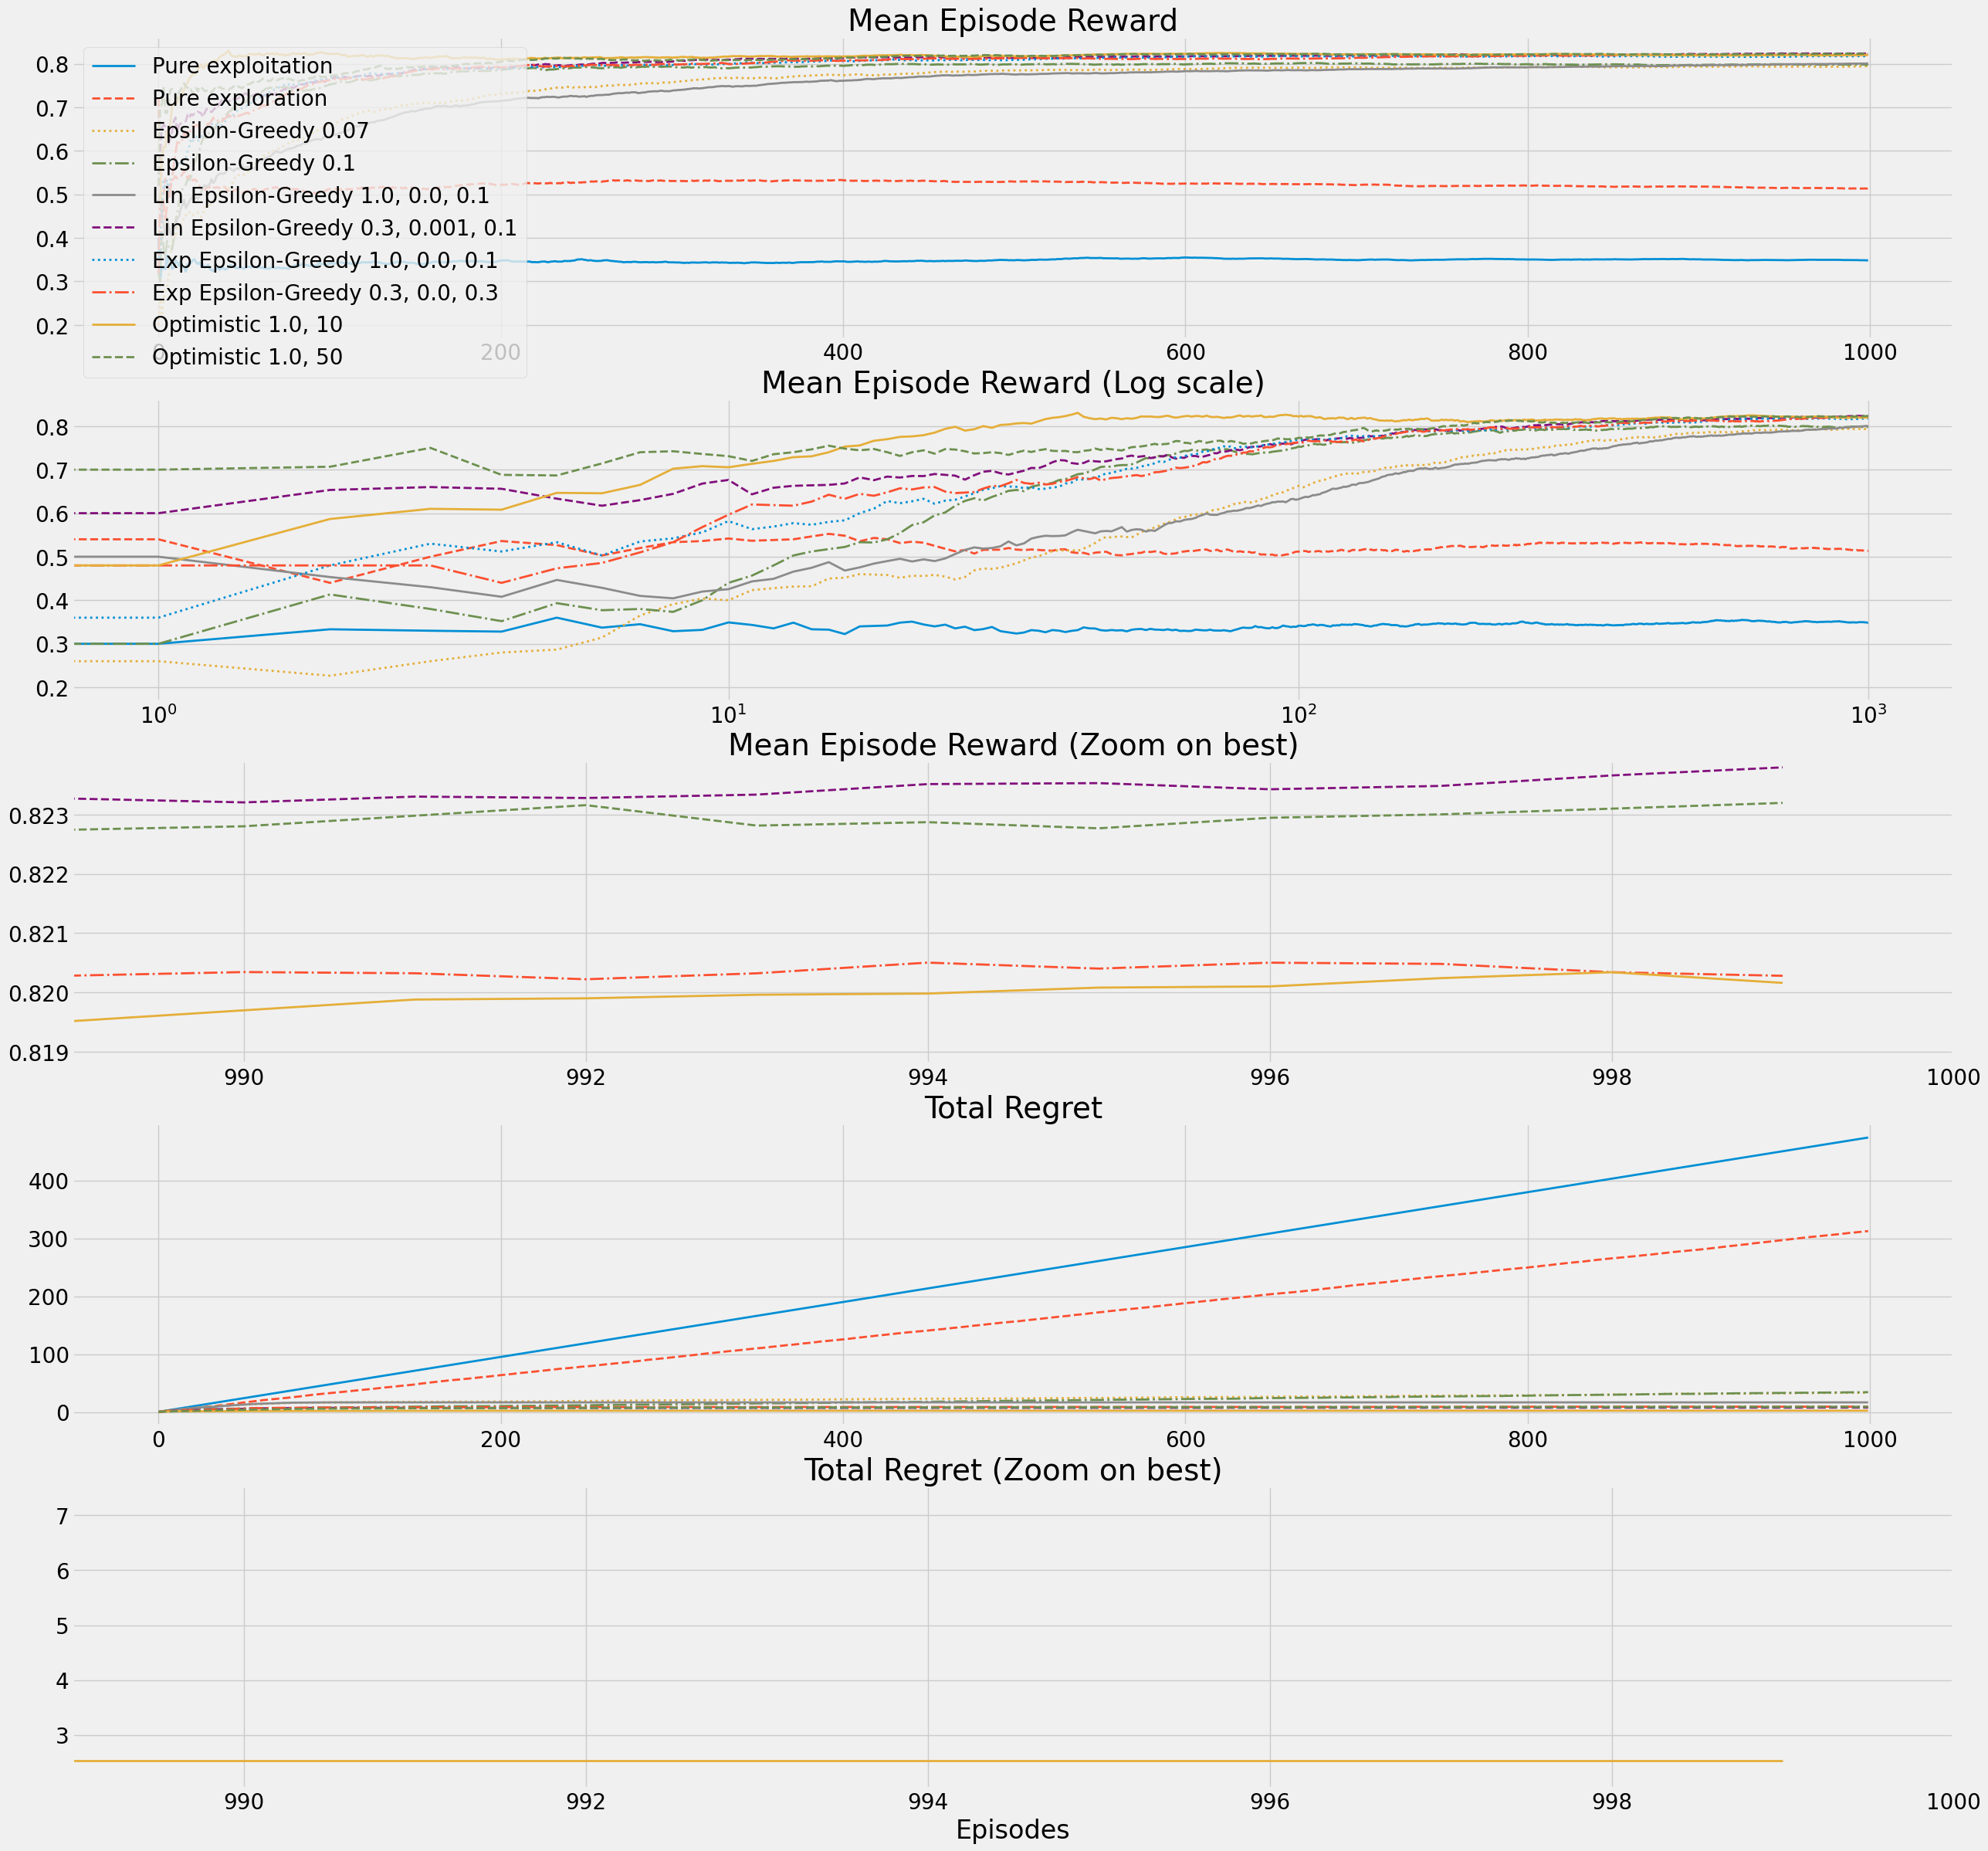

In [57]:
fig, axs = plt.subplots(5, 1, figsize=(28, 28), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b2_results_s.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.005,
                 max_ret+0.0001))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-0.5,
              min_reg+5))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')

plt.show()

# Advanced strategies

In [63]:
def softmax(env,
            init_temp=float('inf'),
            min_temp=0.0,
            decay_ratio=0.04,
            n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int64)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int64)

    name = f'Lin SoftMax {init_temp}, {min_temp}, {decay_ratio}'

    _ = env.reset()
    # float('inf')를 너무 크게 잡지 않도록 약간 보정
    init_temp = min(init_temp, 1e8)
    min_temp = max(min_temp, 1e-8)

    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name,
                  leave=False):
        decay_episodes = n_episodes * decay_ratio
        temp = 1 - e / decay_episodes
        temp *= init_temp - min_temp
        temp += min_temp
        temp = np.clip(temp, min_temp, init_temp)

        scaled_Q = Q / temp
        norm_Q = scaled_Q - np.max(scaled_Q)
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)
        assert np.isclose(probs.sum(), 1.0)

        action = np.random.choice(np.arange(len(probs)), p=probs)
        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

        _ = env.reset()

    return name, returns, Qe, actions

In [65]:
def upper_confidence_bound(env, c=2, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int64)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int64)

    name = f'UCB {c}'
    _ = env.reset()

    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name,
                  leave=False):
        # 초기에는 액션별로 1회씩 선택
        if e < len(Q):
            action = e
        else:
            total_count = e
            # UCB = Q[a] + c * sqrt( ln t / N[a] )
            U = np.sqrt(c * np.log(total_count) / N)
            action = np.argmax(Q + U)

        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

        _ = env.reset()

    return name, returns, Qe, actions


In [66]:
def thompson_sampling(env, alpha=1, beta=0, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int64)

    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int64)
    name = f'Thompson Sampling {alpha}, {beta}'

    _ = env.reset()

    for e in tqdm(range(n_episodes),
                  desc='Episodes for: ' + name,
                  leave=False):
        # 정규분포 기반 TS
        # 표준편차를 alpha/(sqrt(N)+beta) 로 설정
        samples = np.random.normal(loc=Q, scale=alpha / (np.sqrt(N) + beta))
        action = np.argmax(samples)

        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action]) / N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action

        _ = env.reset()

    return name, returns, Qe, actions

# Running advanced strategies on Two-Armed Bandit environments

In [67]:
def b2_run_advanced_strategies_experiment(env_name='BanditTwoArmedUniform-v0'):
    results = {}
    experiments = [
        # baseline strategies
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),

        # best from simple
        lambda env: optimistic_initialization(env,
                                              optimistic_estimate=1.0,
                                              initial_count=10),
        lambda env: exp_dec_epsilon_greedy(env,
                                           init_epsilon=0.3,
                                           min_epsilon=0.0,
                                           decay_ratio=0.3),

        # softmax
        lambda env: softmax(env,
                            init_temp=float('inf'),
                            min_temp=0.0,
                            decay_ratio=0.005),
        lambda env: softmax(env,
                            init_temp=100,
                            min_temp=0.01,
                            decay_ratio=0.01),

        # ucb
        lambda env: upper_confidence_bound(env, c=0.2),
        lambda env: upper_confidence_bound(env, c=0.5),

        # thompson sampling
        lambda env: thompson_sampling(env, alpha=1, beta=1),
        lambda env: thompson_sampling(env, alpha=0.5, beta=0.5),
    ]
    for env_seed in tqdm(SEEDS, desc='All experiments'):
        env = gym.make(env_name, seed=env_seed)
        _ = env.reset()
        true_Q = np.array(env.unwrapped.p_dist * env.unwrapped.r_dist)
        opt_V = np.max(true_Q)

        for seed_ in tqdm(SEEDS, desc='All environments', leave=False):
            env.reset(seed=seed_)
            np.random.seed(seed_)
            random.seed(seed_)

            for experiment in tqdm(experiments,
                                   desc=f'Experiments with seed {seed_}',
                                   leave=False):
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)

                if name not in results:
                    results[name] = {}
                if 'Re' not in results[name]:
                    results[name]['Re'] = []
                if 'Qe' not in results[name]:
                    results[name]['Qe'] = []
                if 'Ae' not in results[name]:
                    results[name]['Ae'] = []
                if 'cum_regret' not in results[name]:
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name]:
                    results[name]['episode_mean_rew'] = []

                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)

    return results


b2_results_a = b2_run_advanced_strategies_experiment()

All experiments:   0%|          | 0/5 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

# Plotting results of advanced strategies on Two-Armed Bandit  environments

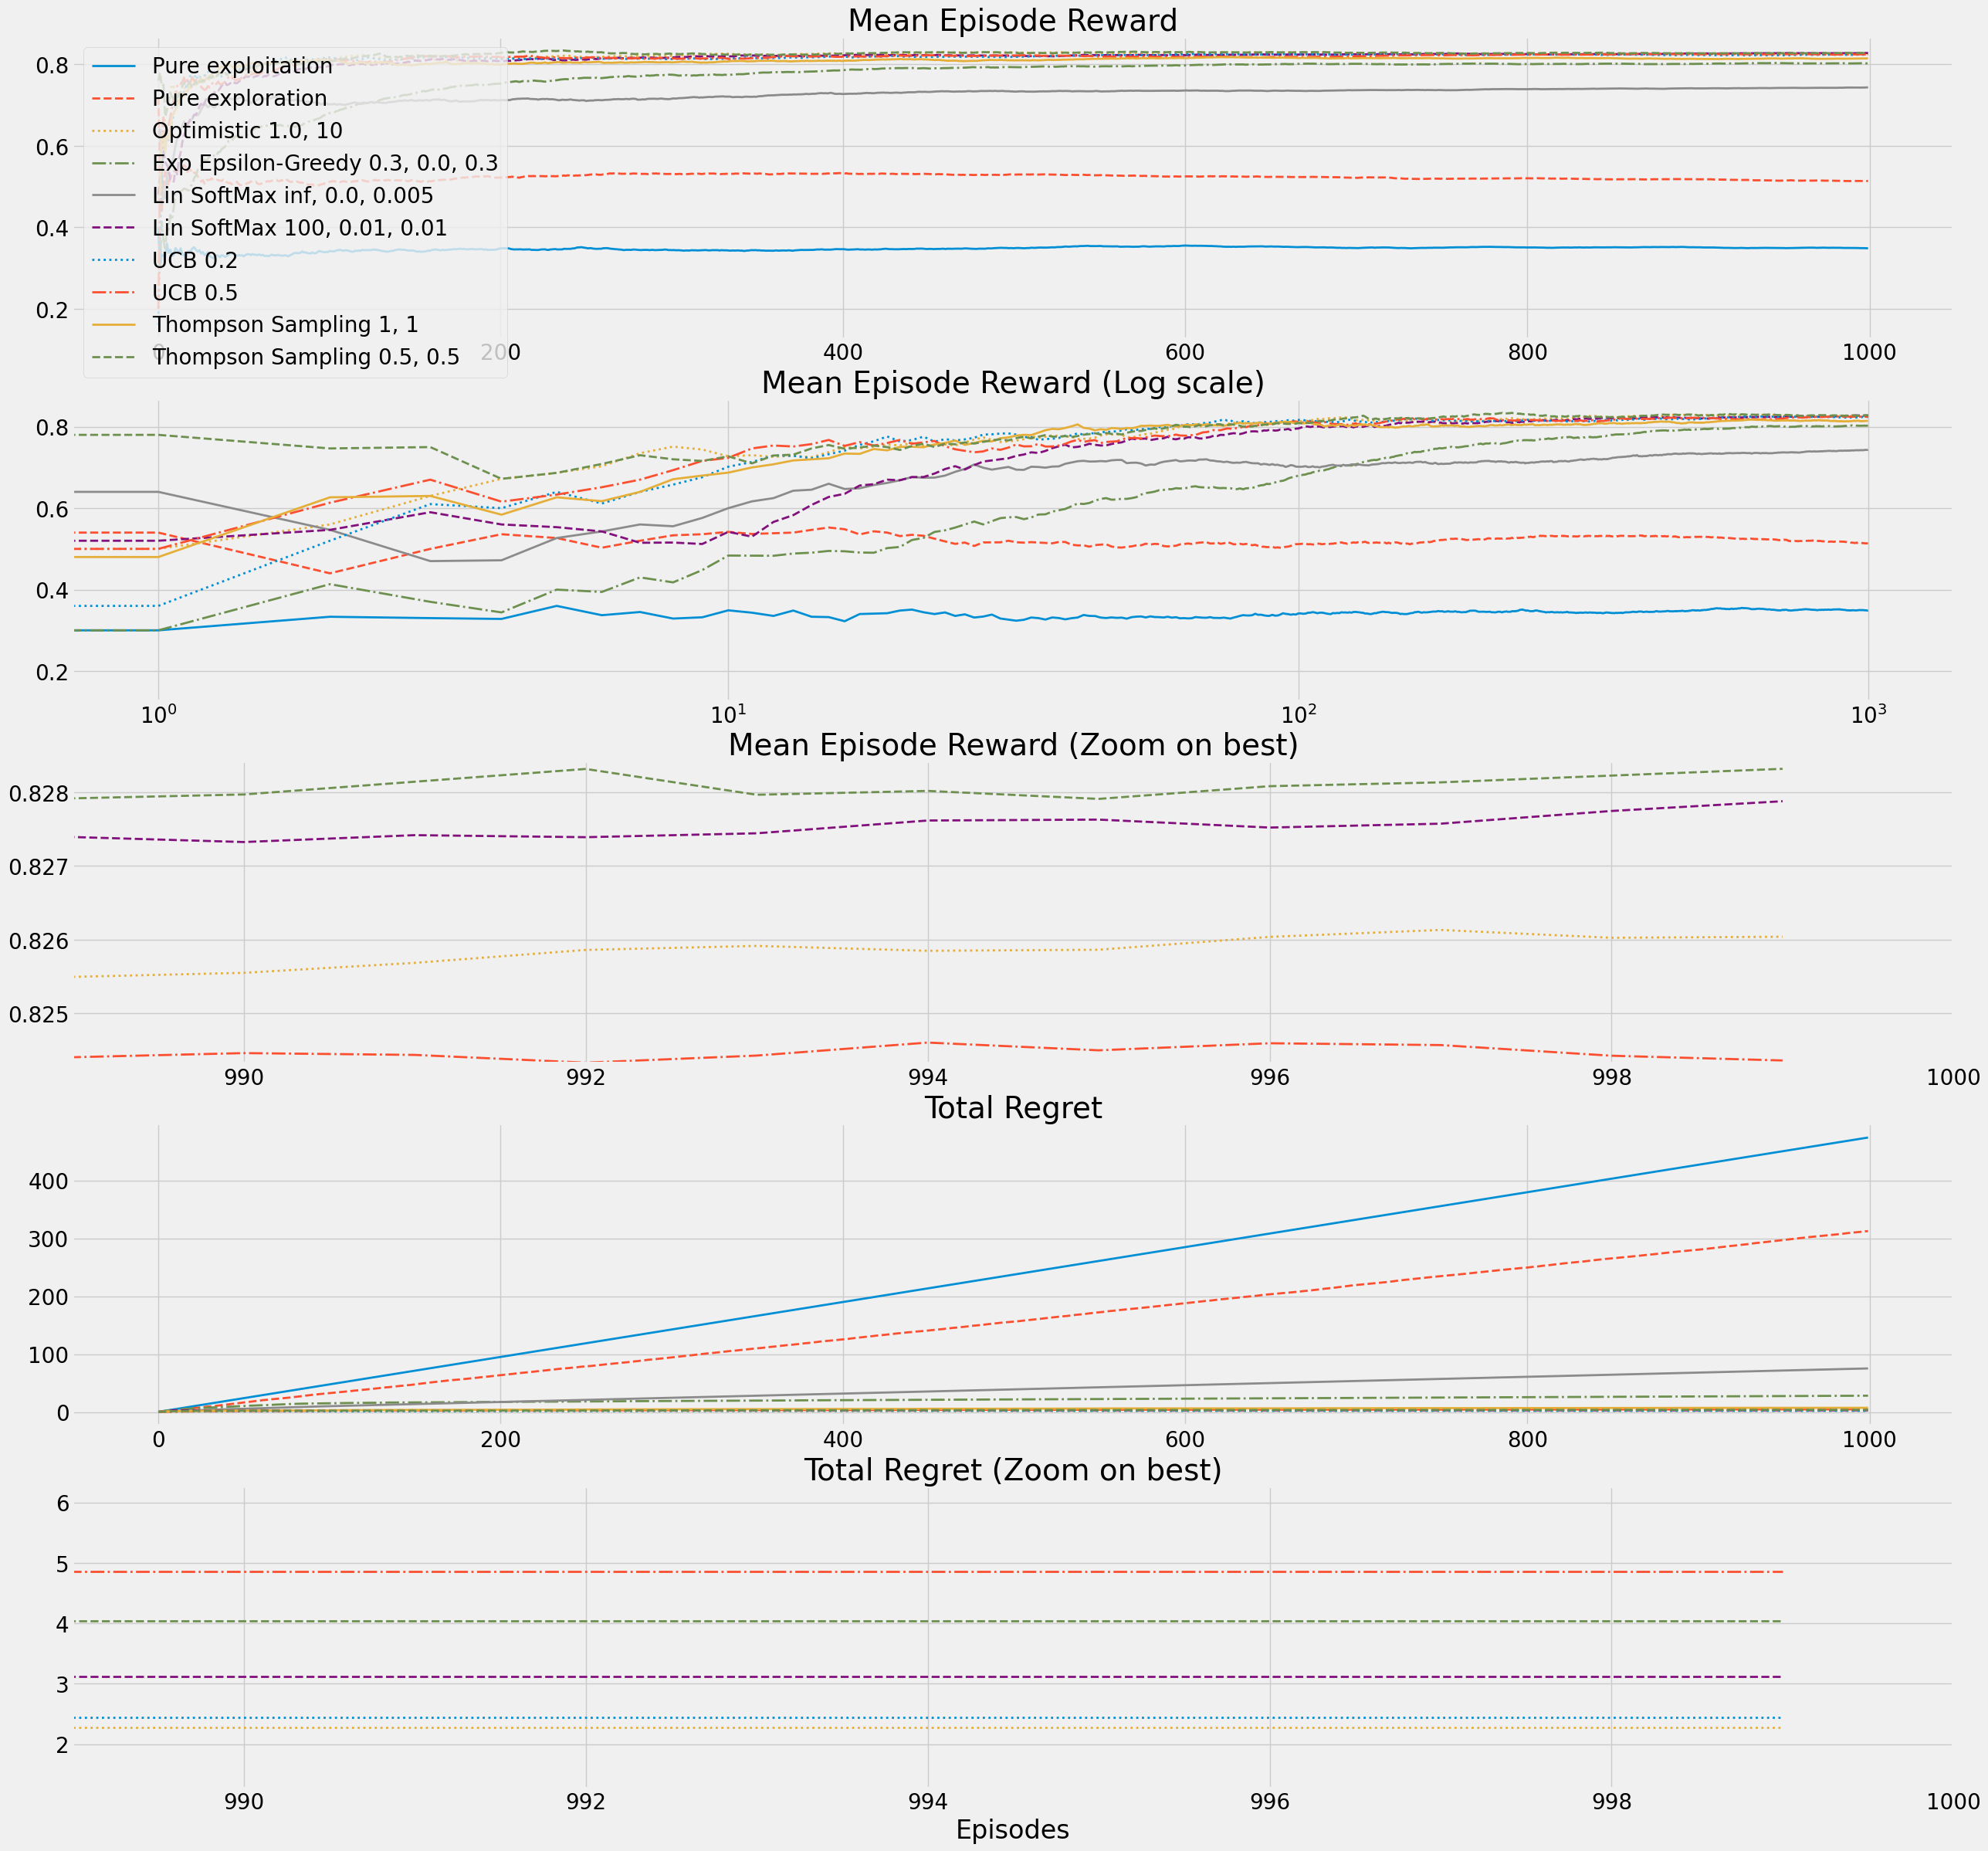

In [68]:
fig, axs = plt.subplots(5, 1, figsize=(28, 28), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b2_results_a.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.004,
                 max_ret+0.0001))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-1,
              min_reg+4))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')
    
plt.show()

# 10-Armed Gaussian Bandit environments

In [70]:
b10_Vs = []
for seed in SEEDS:
    env_name = 'BanditTenArmedGaussian-v0'
    env = gym.make(env_name, seed=seed)
    _ = env.reset()
    r_dist = np.array(env.unwrapped.r_dist)[:, 0]
    b10_Q = np.array(env.unwrapped.p_dist * r_dist)
    print('10-Armed Bandit environment with seed', seed)
    print('Probability of reward:', env.unwrapped.p_dist)
    print('Reward:', r_dist)
    print('Q(.):', b10_Q)
    b10_Vs.append(np.max(b10_Q))
    print('V*:', b10_Vs[-1])
    print()

print('Mean V* across all seeds:', np.mean(b10_Vs))

10-Armed Bandit environment with seed 12
Probability of reward: [1 1 1 1 1 1 1 1 1 1]
Reward: [-0.00682678  1.04614329  0.74158842  0.72395654  1.61877622 -1.20555814
 -0.62695547 -1.32066321 -0.10775251  0.99876366]
Q(.): [-0.00682678  1.04614329  0.74158842  0.72395654  1.61877622 -1.20555814
 -0.62695547 -1.32066321 -0.10775251  0.99876366]
V*: 1.6187762233340763

10-Armed Bandit environment with seed 34
Probability of reward: [1 1 1 1 1 1 1 1 1 1]
Reward: [-0.03992466 -1.25773672  2.57402319  0.48179798  0.64354662 -0.20792668
  0.05828708  0.33674264  0.19510709 -0.60931449]
Q(.): [-0.03992466 -1.25773672  2.57402319  0.48179798  0.64354662 -0.20792668
  0.05828708  0.33674264  0.19510709 -0.60931449]
V*: 2.574023189963745

10-Armed Bandit environment with seed 56
Probability of reward: [1 1 1 1 1 1 1 1 1 1]
Reward: [-0.84994072  0.32194085  1.78904286  0.8793392   0.37159282  1.48769378
  0.72866553  2.08124873 -1.33726808  0.12535155]
Q(.): [-0.84994072  0.32194085  1.78904286  

# Running simple strategies on 10-Armed Bandit environments

In [72]:
def b10_run_simple_strategies_experiment(env_name='BanditTenArmedGaussian-v0'):
    results = {}
    experiments = [
        # baseline strategies
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),

        # epsilon greedy
        lambda env: epsilon_greedy(env, epsilon=0.07),
        lambda env: epsilon_greedy(env, epsilon=0.1),

        # epsilon greedy linearly decaying
        lambda env: lin_dec_epsilon_greedy(env,
                                           init_epsilon=1.0,
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: lin_dec_epsilon_greedy(env,
                                           init_epsilon=0.3,
                                           min_epsilon=0.001,
                                           decay_ratio=0.1),

        # epsilon greedy exponentially decaying
        lambda env: exp_dec_epsilon_greedy(env,
                                           init_epsilon=1.0,
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: exp_dec_epsilon_greedy(env,
                                           init_epsilon=0.3,
                                           min_epsilon=0.0,
                                           decay_ratio=0.3),

        # optimistic
        lambda env: optimistic_initialization(env,
                                              optimistic_estimate=1.0,
                                              initial_count=10),
        lambda env: optimistic_initialization(env,
                                              optimistic_estimate=1.0,
                                              initial_count=50),
    ]
    for env_seed in tqdm(SEEDS, desc='All experiments'):
        env = gym.make(env_name, seed=env_seed)
        _ = env.reset()
        r_dist = np.array(env.unwrapped.r_dist)[:, 0]
        true_Q = np.array(env.unwrapped.p_dist * r_dist)
        opt_V = np.max(true_Q)

        for seed_ in tqdm(SEEDS, desc='All environments', leave=False):
            env.reset(seed=seed_)
            np.random.seed(seed_)
            random.seed(seed_)

            for experiment in tqdm(experiments,
                                   desc=f'Experiments with seed {seed_}',
                                   leave=False):
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)

                if name not in results:
                    results[name] = {}
                if 'Re' not in results[name]:
                    results[name]['Re'] = []
                if 'Qe' not in results[name]:
                    results[name]['Qe'] = []
                if 'Ae' not in results[name]:
                    results[name]['Ae'] = []
                if 'cum_regret' not in results[name]:
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name]:
                    results[name]['episode_mean_rew'] = []

                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)

    return results


b10_results_s = b10_run_simple_strategies_experiment()

All experiments:   0%|          | 0/5 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.07:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Epsilon-Greedy 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

# Plotting results of simple strategies on 10-Armed Bandit environments

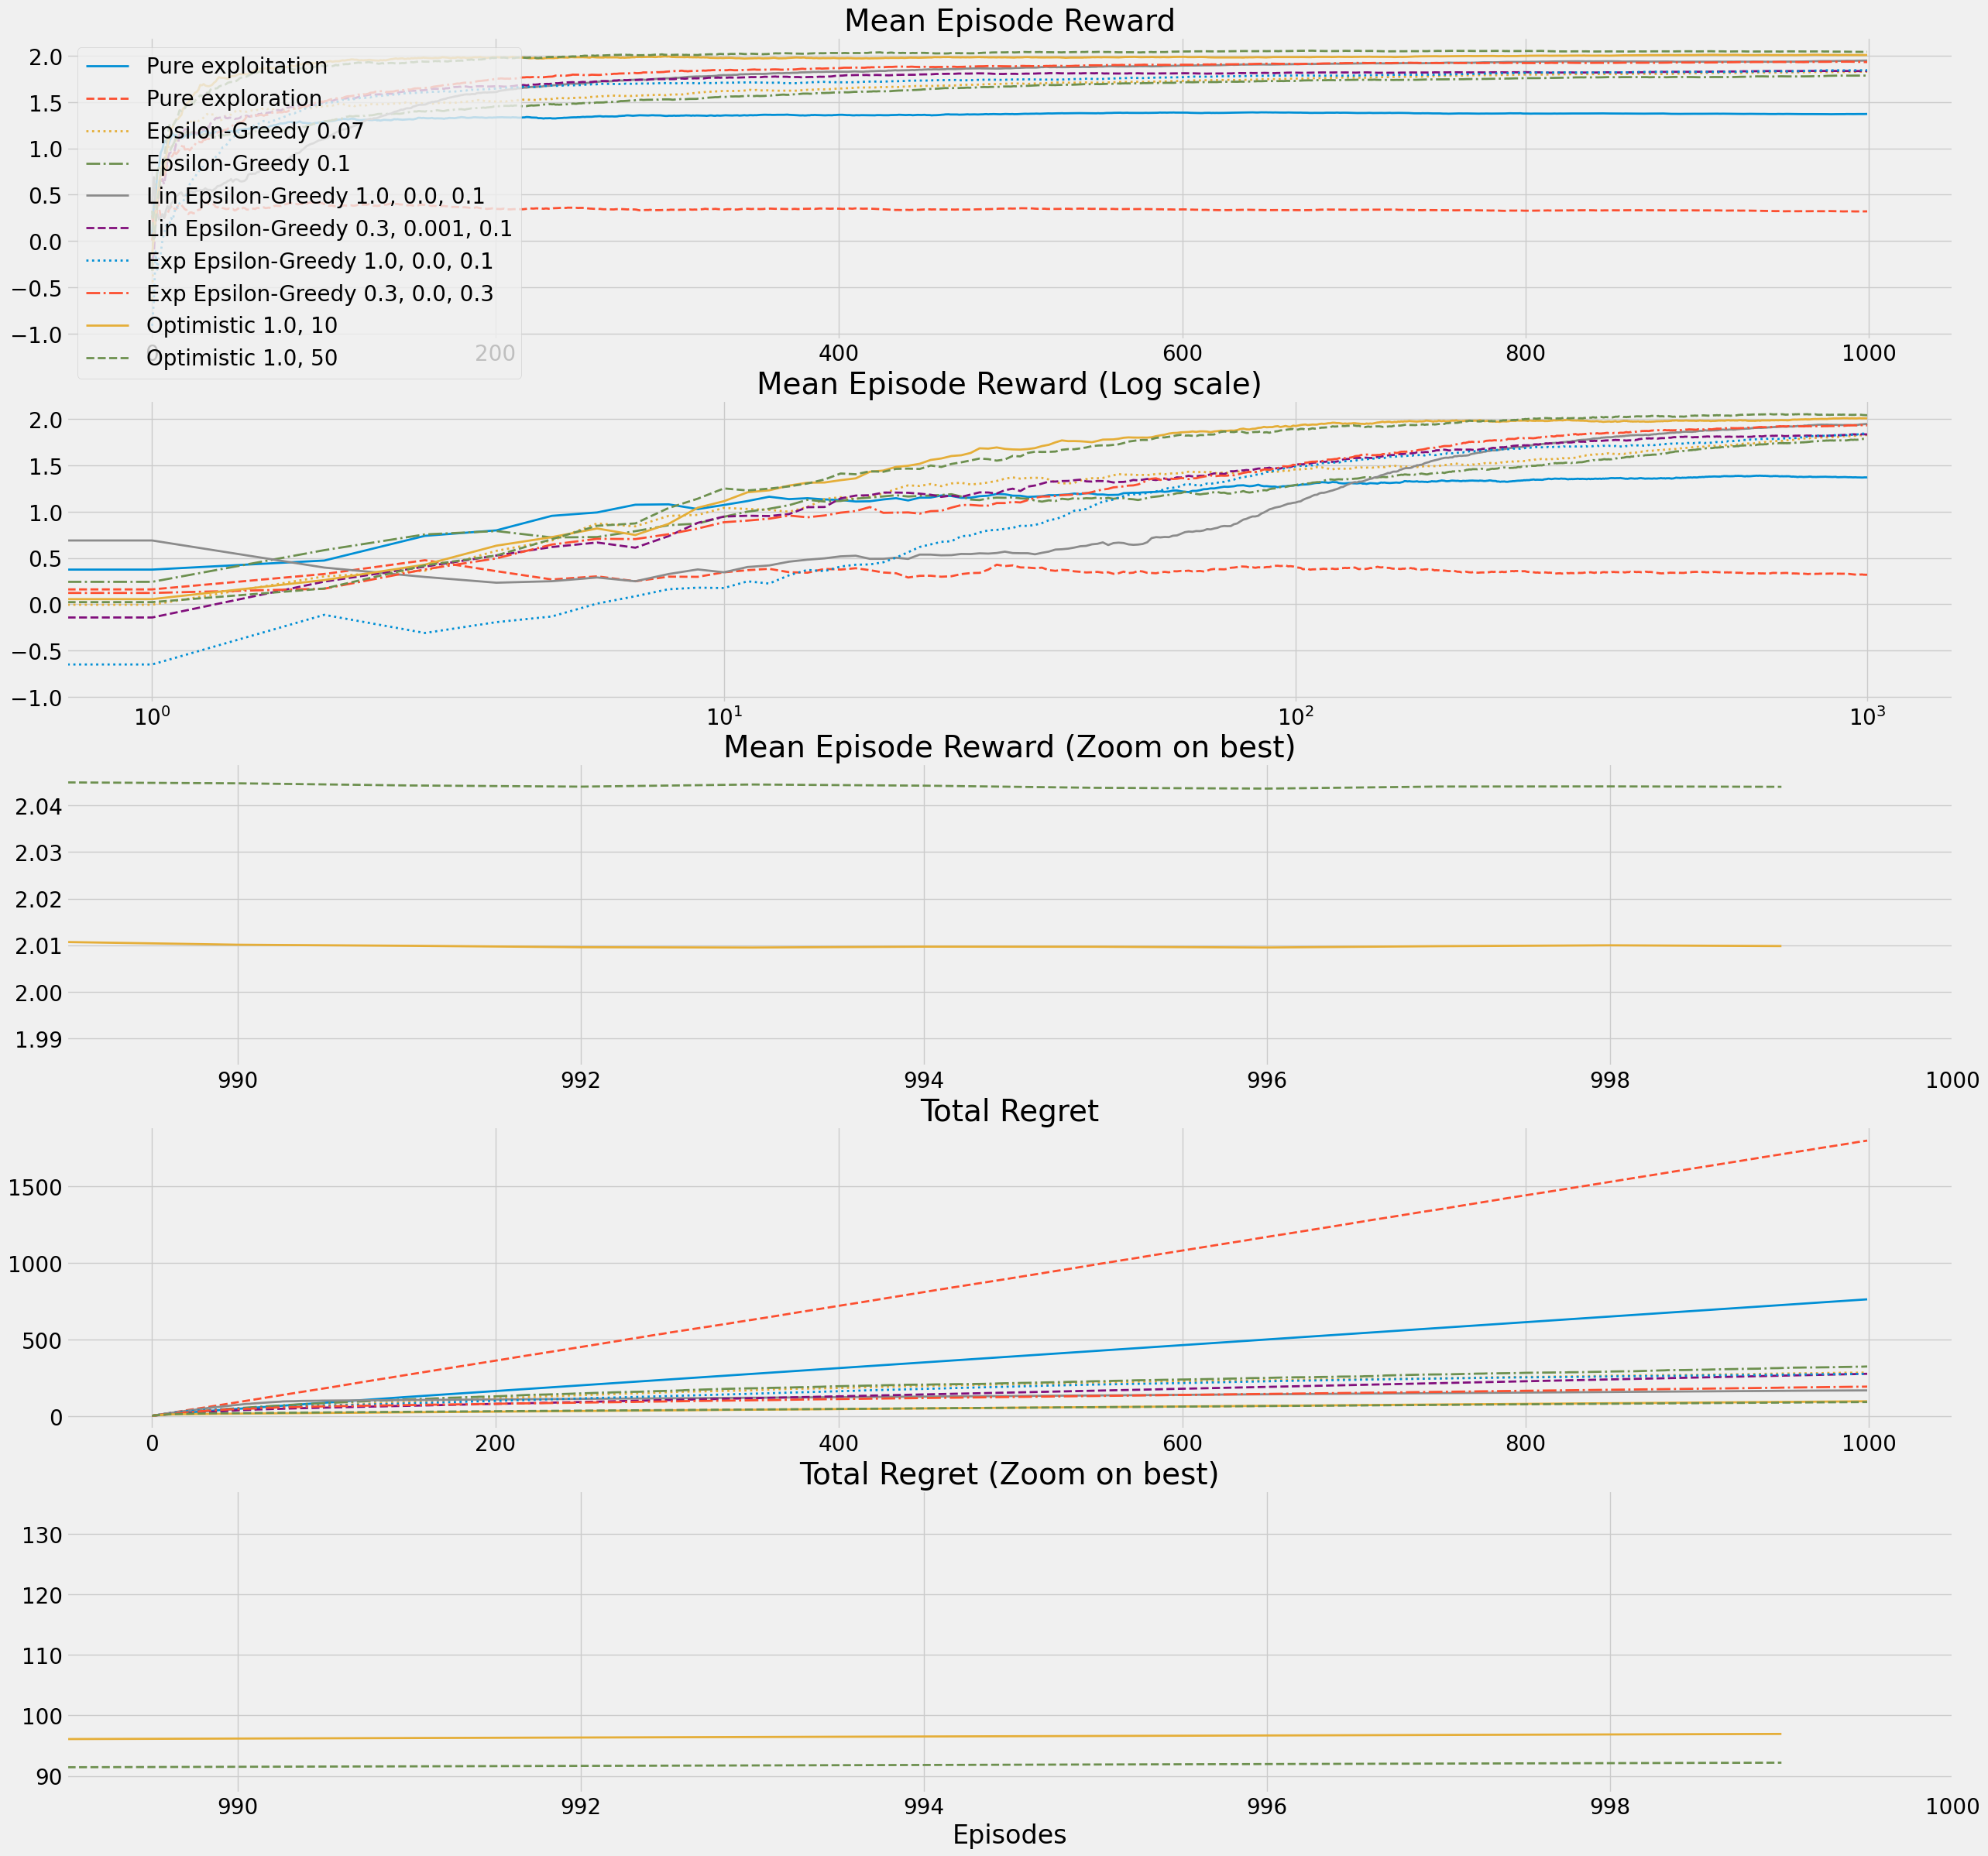

In [73]:
fig, axs = plt.subplots(5, 1, figsize=(28, 28), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b10_results_s.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.06,
                 max_ret+0.005))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-5,
              min_reg+45))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')

plt.show()

# Running advanced strategies on 10-Armed Bandit environments

In [75]:
def b10_run_advanced_strategies_experiment(env_name='BanditTenArmedGaussian-v0'):
    results = {}
    experiments = [
        # baseline
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),

        # best from simple strategies
        lambda env: lin_dec_epsilon_greedy(env,
                                           init_epsilon=1.0,
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),
        lambda env: exp_dec_epsilon_greedy(env,
                                           init_epsilon=1.0,
                                           min_epsilon=0.0,
                                           decay_ratio=0.1),

        # softmax
        lambda env: softmax(env,
                            init_temp=float('inf'),
                            min_temp=0.0,
                            decay_ratio=0.005),
        lambda env: softmax(env,
                            init_temp=100,
                            min_temp=0.01,
                            decay_ratio=0.01),

        # ucb
        lambda env: upper_confidence_bound(env, c=0.2),
        lambda env: upper_confidence_bound(env, c=0.5),

        # thompson sampling
        lambda env: thompson_sampling(env, alpha=1, beta=1),
        lambda env: thompson_sampling(env, alpha=0.5, beta=0.5),
    ]

    for env_seed in tqdm(SEEDS, desc='All experiments'):
        env = gym.make(env_name, seed=env_seed)
        _ = env.reset()
        r_dist = np.array(env.unwrapped.r_dist)[:, 0]
        true_Q = np.array(env.unwrapped.p_dist * r_dist)
        opt_V = np.max(true_Q)

        for seed_ in tqdm(SEEDS, desc='All environments', leave=False):
            env.reset(seed=seed_)
            np.random.seed(seed_)
            random.seed(seed_)

            for experiment in tqdm(experiments,
                                   desc=f'Experiments with seed {seed_}',
                                   leave=False):
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)

                if name not in results:
                    results[name] = {}
                if 'Re' not in results[name]:
                    results[name]['Re'] = []
                if 'Qe' not in results[name]:
                    results[name]['Qe'] = []
                if 'Ae' not in results[name]:
                    results[name]['Ae'] = []
                if 'cum_regret' not in results[name]:
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name]:
                    results[name]['episode_mean_rew'] = []

                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results


b10_results_a = b10_run_advanced_strategies_experiment()

All experiments:   0%|          | 0/5 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax inf, 0.0, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: UCB 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 1, 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Thompson Sampling 0.5, 0.5:   0%|          | 0/1000 [00:00<?, ?it/s]

# Plotting results of advanced strategies on 10-Armed Bandit environments

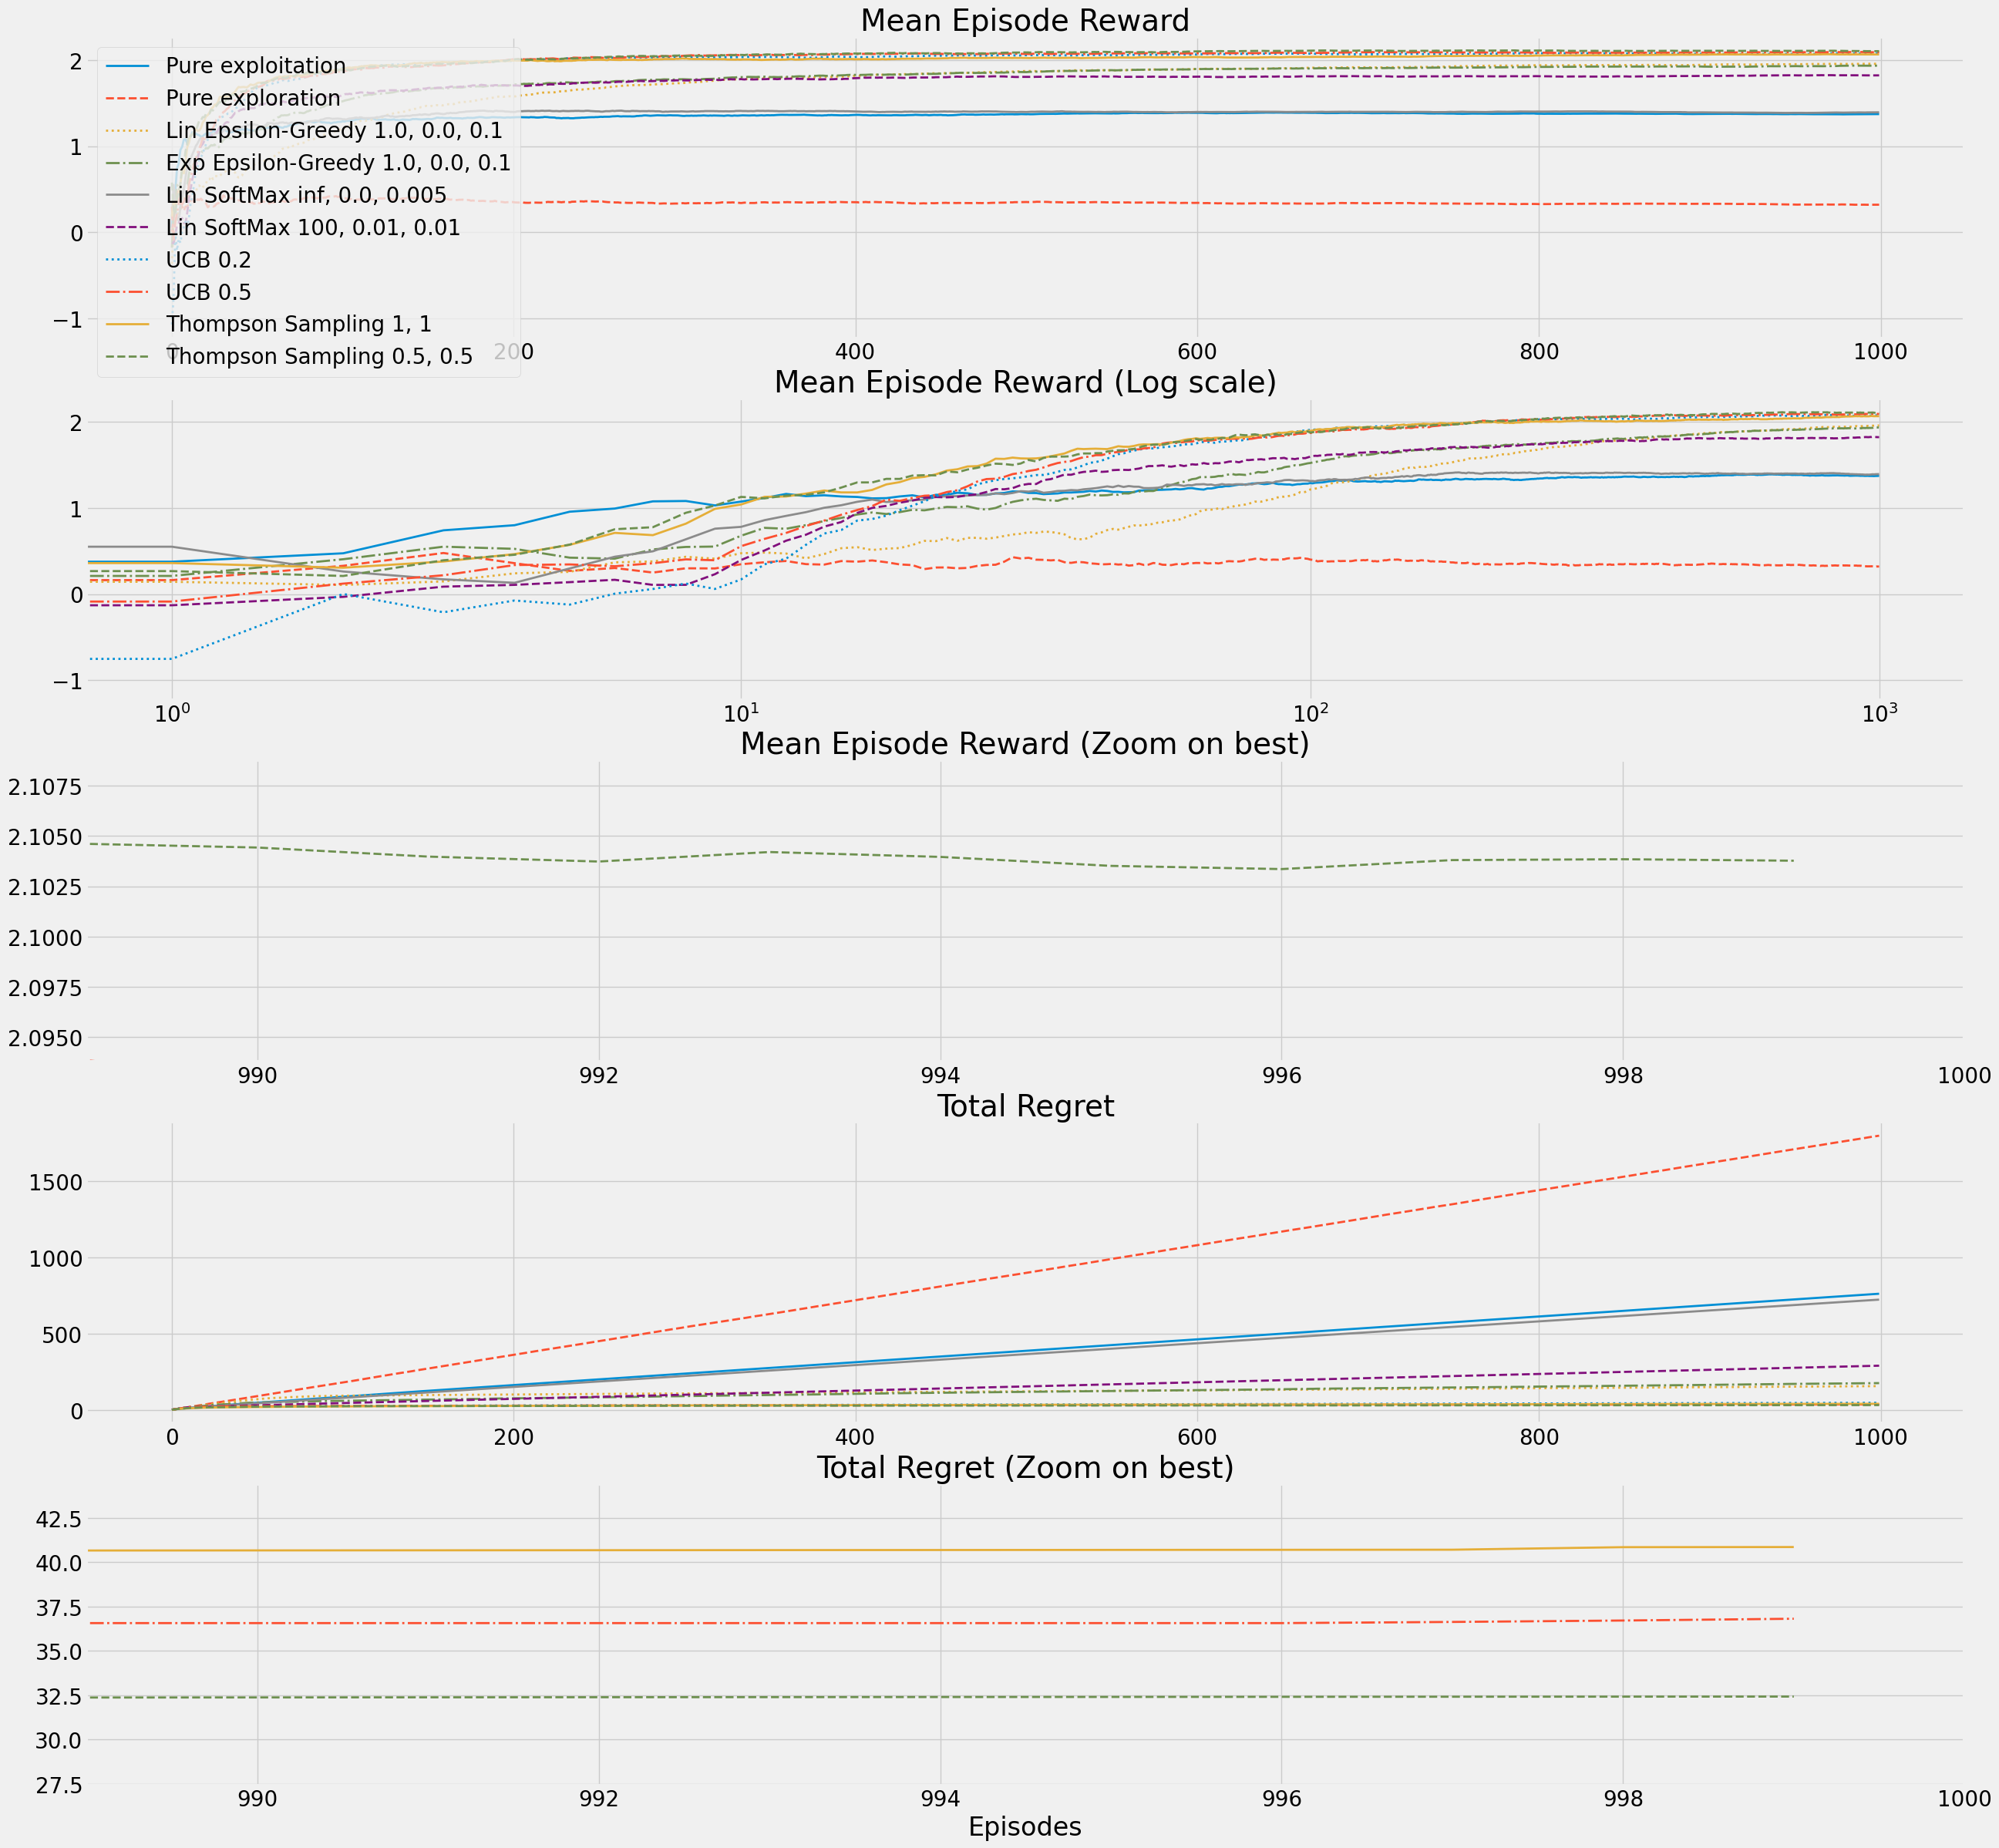

In [76]:
fig, axs = plt.subplots(5, 1, figsize=(28, 28), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b10_results_a.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((mean_episode_mean_rew.shape[0]*0.989,
                 mean_episode_mean_rew.shape[0],
                 max_ret-0.01,
                 max_ret+0.005))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((mean_cum_regret.shape[0]*0.989,
              mean_cum_regret.shape[0],
              min_reg-5,
              min_reg+12))

    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')

plt.show()